In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download a compressed archive containing the cat and dog images.
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# Extracted the archive
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Defined paths
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Set hyperparameters:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Create a TensorFlow image dataset from the train directory
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 312s 5us/step
Found 2000 files belonging to 2 classes.


In [3]:
# Create image datasets from directories containing images and labels
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

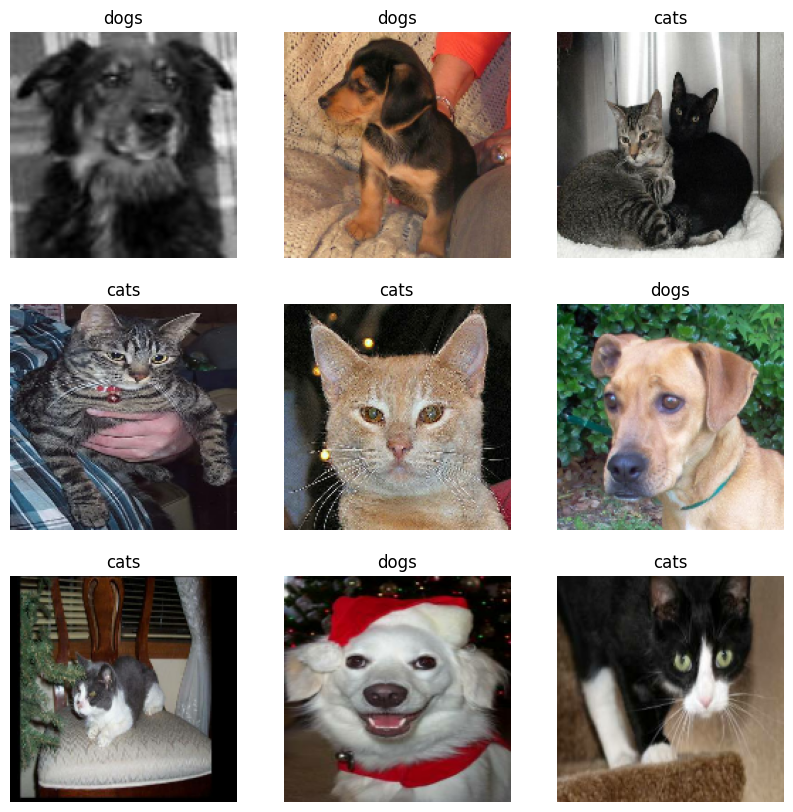

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Counts the total number of batches in the validation_dataset. 
val_batches = tf.data.experimental.cardinality(validation_dataset)

#  takes the first val_batches // 5 batches from the
#  validation_dataset to create the test_dataset
test_dataset = validation_dataset.take(val_batches // 5)

# Skips the first val_batches // 5 batches from
# The original validation_dataset
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), # Randomly flips images horizontally with a 50% probability.
  tf.keras.layers.RandomRotation(0.2), # randomly rotates images by up to 0.2 radians 
])

In [15]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

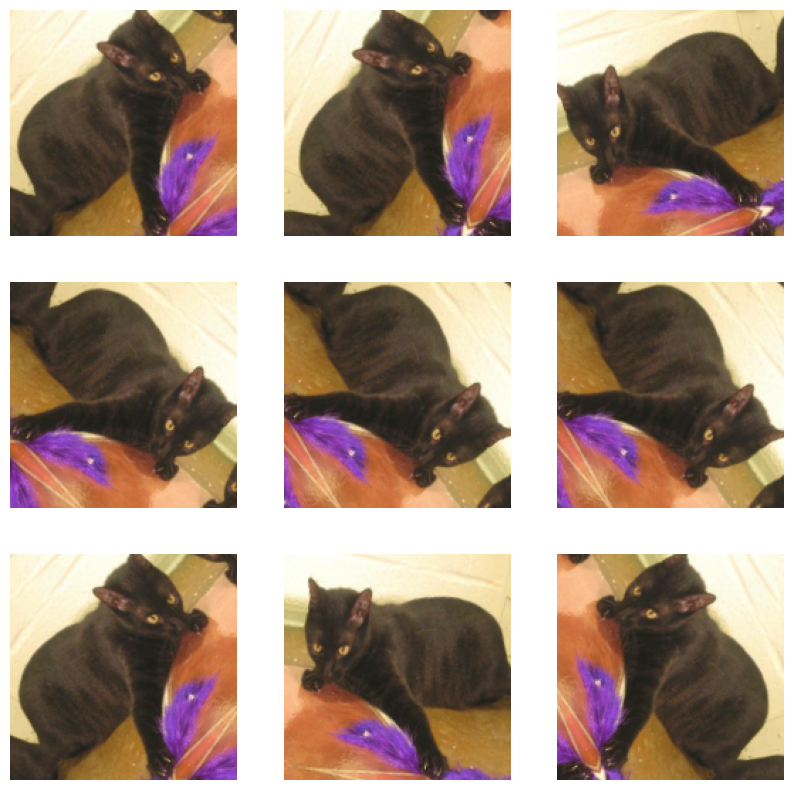

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) #  add batch dimension to the image, making it compatible with the data_augmentation pipeline
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
# preparing images for use with the MobileNetV2 pre-trained model. 
# Resize img - Normilize pixel - Expands to batch dimensions 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-2,2] --> [-1,1]

In [21]:
# combines the image size you defined earlier (160, 160) with an additional dimension for 
# color channels (3 for RGB images). This results in (160, 160, 3)
IMG_SHAPE = IMG_SIZE + (3,) 
IMG_SHAPE

(160, 160)

In [19]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, # expected input image shape
                                               include_top=False, # excludes the final classification layers of the pre-trained model, as you want to add your own for cat/dog classification.
                                               weights='imagenet') # loads the pre-trained weights trained on the ImageNet dataset


9406464/9406464 [==============================] - 96s 10us/step


In [22]:
# retrieves a batch of images and their corresponding labels 
# from the training dataset. This uses the next function 
# to iterate over the dataset and get the first batch.
image_batch, label_batch = next(iter(train_dataset))
# extracts features from the images using the
# pre-trained layers of MobileNetV2.
feature_batch = base_model(image_batch)
#  This means the model extracts 1280 features for each image,
# arranged in a 5x5 grid for each image in the batch.
print(feature_batch.shape) # (batch_size, height, width, channels)

(32, 5, 5, 1280)


In [23]:
# freezes the weights of the pre-trained MobileNetV2
# base model in your image classification task
base_model.trainable = False

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [25]:
# This layer performs global average pooling, which means it calculates 
# the average value for each channel across the entire spatial dimensions
# (height and width) of the input feature maps.
# Think of it as summarizing the information contained in each feature 
# map into a single value.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# the layer reduces the spatial dimensions and keeps the number of channels (features),
# resulting in a vector with 1280 values for each image in the batch.
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [26]:
#  fully-connected layer with one output neuron(cat, dog).
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)
